# 实验Magics的绘图程序

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import datetime as dt
import scipy.ndimage as ndimage
import metpy
import streamlit as st

import Magics.macro as magics

In [67]:
def load_variables(date_obj, map_region=[50, 160, 6, 60]):
    """
    Load the variables from UAlbany's opendap server

    Args:
        date_obj (datetime): a datetime object
    """

    # To make parsing the date easier, convert it into a datetime object
    # and get it into various formats
    yyyy = date_obj.year

    # set filepath template
    filepath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CFSR/%s/%s.%s.0p5.anl.nc"%(yyyy,'%s',yyyy)

    # construct sub region
    sub_region = {'lon':slice(map_region[0], map_region[1]),
                  'lat':slice(map_region[2], map_region[3])}

    # Subset and load data
    subdata = {}
    st.info('Load CFSR from http://thredds.atmos.albany.edu:8080/thredds/dodsC/ (taking 20s)')

    # wind field
    my_bar = st.progress(0)
    data = xr.open_mfdataset([filepath%('u'), filepath%('v')], combine='by_coords', cache=False)
    data = data.sel(time=date_obj)           
    subdata['u200'] = data['u'].sel(lev=200, **sub_region).load()      ; my_bar.progress(5)
    subdata['v200'] = data['v'].sel(lev=200, **sub_region).load()      ; my_bar.progress(10)
    subdata['u500'] = data['u'].sel(lev=500, **sub_region).load()      ; my_bar.progress(15)
    subdata['v500'] = data['v'].sel(lev=500, **sub_region).load()      ; my_bar.progress(20)
    subdata['u700'] = data['u'].sel(lev=700, **sub_region).load()      ; my_bar.progress(23)
    subdata['v700'] = data['v'].sel(lev=700, **sub_region).load()      ; my_bar.progress(25)
    subdata['u850'] = data['u'].sel(lev=850, **sub_region).load()      ; my_bar.progress(28)
    subdata['v850'] = data['v'].sel(lev=850, **sub_region).load()      ; my_bar.progress(30)
    subdata['u925'] = data['u'].sel(lev=925, **sub_region).load()      ; my_bar.progress(35)
    subdata['v925'] = data['v'].sel(lev=925, **sub_region).load()      ; my_bar.progress(40)

    # vertical velocity field
    data = xr.open_dataset(filepath%('w'), cache=False)
    data = data.sel(time=date_obj)
    subdata['w700'] = data['w'].sel(lev=700, **sub_region).load()      ; my_bar.progress(45)

    # pressure on pv surface
    data = xr.open_dataset(filepath%('pres_pv'), cache=False)
    data = data.sel(time=date_obj)
    subdata['pres_pv2'] = data['pres_pv'].sel(lev=2.0E-6, **sub_region).load()   ; my_bar.progress(50)
    subdata['pres_pv2'].metpy.convert_units('hPa')

    # geopotential height
    data = xr.open_dataset(filepath%('g'), cache=False)
    data = data.sel(time=date_obj)   
    subdata['gh200'] = data['g'].sel(lev=200, **sub_region).load()  ; my_bar.progress(55)
    subdata['gh500'] = data['g'].sel(lev=500, **sub_region).load()  ; my_bar.progress(60)
    subdata['gh700'] = data['g'].sel(lev=700, **sub_region).load()  ; my_bar.progress(62)

    # high temperature
    data = xr.open_dataset(filepath%('t'), cache=False)
    data = data.sel(time=date_obj)
    subdata['t500'] = data['t'].sel(lev=500, **sub_region).load()   ; my_bar.progress(64)
    subdata['t700'] = data['t'].sel(lev=700, **sub_region).load()   ; my_bar.progress(66)
    subdata['t850'] = data['t'].sel(lev=850, **sub_region).load()   ; my_bar.progress(68)
    subdata['t925'] = data['t'].sel(lev=925, **sub_region).load()   ; my_bar.progress(70)
    subdata['t500'].metpy.convert_units('degC')
    subdata['t700'].metpy.convert_units('degC')
    subdata['t850'].metpy.convert_units('degC')
    subdata['t925'].metpy.convert_units('degC')
    
    # high moisture field
    data = xr.open_dataset(filepath%('q'), cache=False)
    data = data.sel(time=date_obj) 
    subdata['q700'] = data['q'].sel(lev=700, **sub_region).load()   ; my_bar.progress(73)
    subdata['q850'] = data['q'].sel(lev=850, **sub_region).load()   ; my_bar.progress(75)
    subdata['q925'] = data['q'].sel(lev=925, **sub_region).load()   ; my_bar.progress(80)

    # mean sea level pressure
    data = xr.open_dataset(filepath%('pmsl'), cache=False)
    data = data.sel(time=date_obj) 
    subdata['mslp'] = data['pmsl'].sel(**sub_region).load()         ; my_bar.progress(85)
    subdata['mslp'].metpy.convert_units('hPa')

    # precipitable water
    data = xr.open_dataset(filepath%('pwat'), cache=False)
    data = data.sel(time=date_obj) 
    subdata['pwat'] = data['pwat'].sel(**sub_region).load()         ; my_bar.progress(90)
    subdata['pwat'].metpy.convert_units('mm')

    return subdata

In [68]:
%%time
date_obj = dt.datetime.strptime('2018071912','%Y%m%d%H')
data = load_variables(date_obj)

CPU times: user 389 ms, sys: 59.8 ms, total: 448 ms
Wall time: 25.3 s


# 绘制700hPa垂直速度场

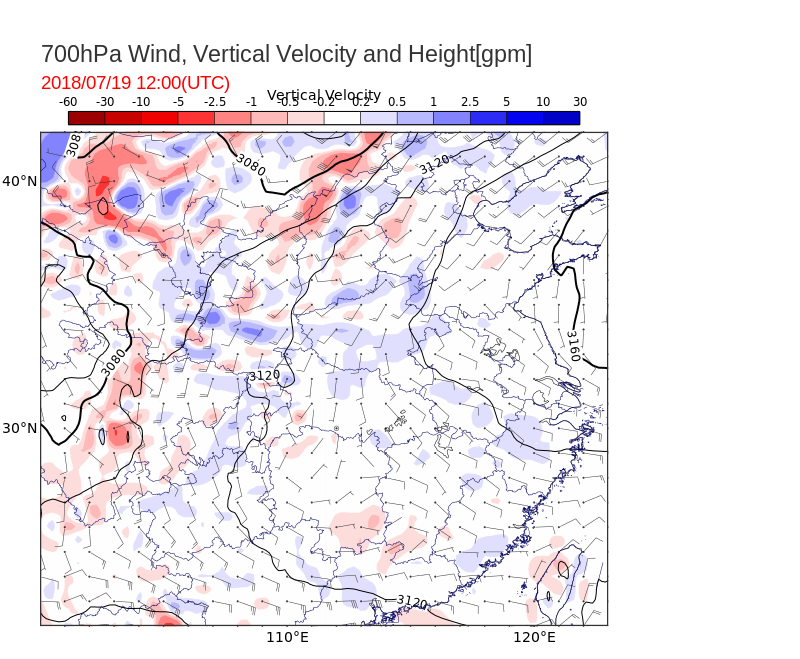

In [70]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import dynamics    
plot = dynamics.draw_vvel_high(data['u700'].values, data['v700'].values, data['w700'].values, 
                               data['w700']['lon'].values, data['w700']['lat'].values,
                               gh=data['gh700'].values, map_region=map_regions['华中'], date_obj=date_obj, skip_vector=2)
plot

# 绘制相对湿度场

In [36]:
import metpy.calc as calc
from metpy.units import units

rh = calc.relative_humidity_from_specific_humidity(data['q850'], data['t850'], 85000 * units.Pa) * 100

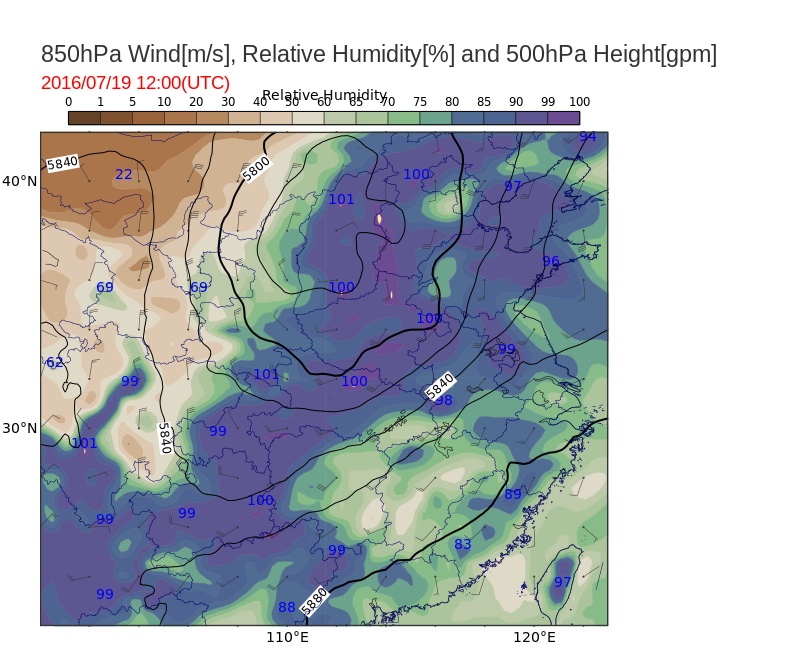

In [40]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import moisture    
plot = moisture.draw_rh_high(data['u500'].values, data['v500'].values, rh.magnitude, data['u500']['lon'].values, data['u500']['lat'].values,
                             gh=data['gh500'].values, map_region=map_regions['华中'], date_obj=date_obj)
plot

# 绘制比湿场

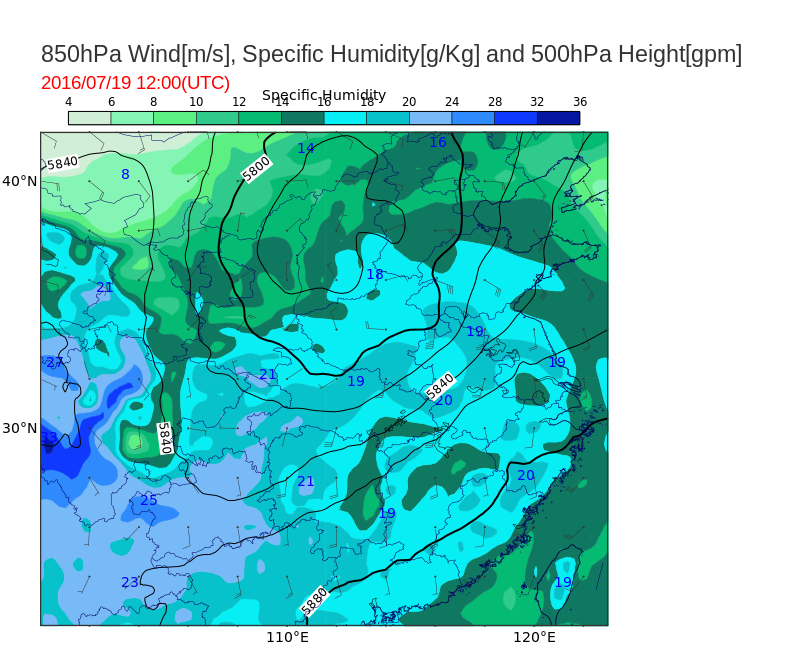

In [58]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import moisture    
plot = moisture.draw_sp_high(data['u925'].values, data['v925'].values, data['q925'].values*1000., data['u925']['lon'].values, data['u925']['lat'].values,
                             gh=data['gh500'].values, map_region=map_regions['华中'], date_obj=date_obj)
plot

# 绘制500hPa高度场和温度场

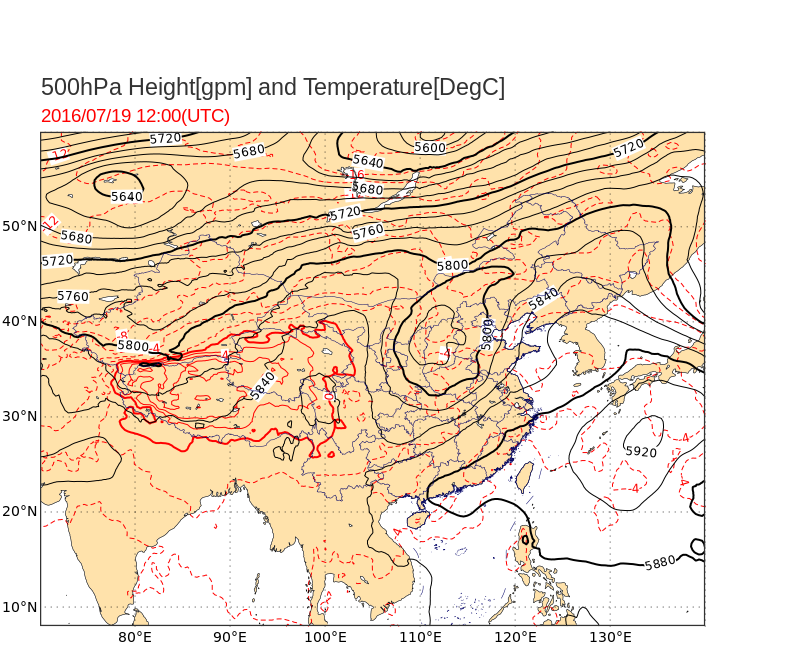

In [65]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import dynamics    
plot = dynamics.draw_height_temp(data['gh500'].values, data['t500'].values, data['gh500']['lon'].values, data['gh500']['lat'].values,
                                 map_region=map_regions['中国'], date_obj=date_obj)
plot

# 绘制500hPa涡度场

In [109]:
import metpy.calc as calc
from metpy.units import units

dx, dy = calc.lat_lon_grid_deltas(data['u500'].lon.values, data['u500'].lat.values)
vort = calc.vorticity(data['u500'].values* units.meter / units.second, data['v500'].values* units.meter / units.second, dx, dy)

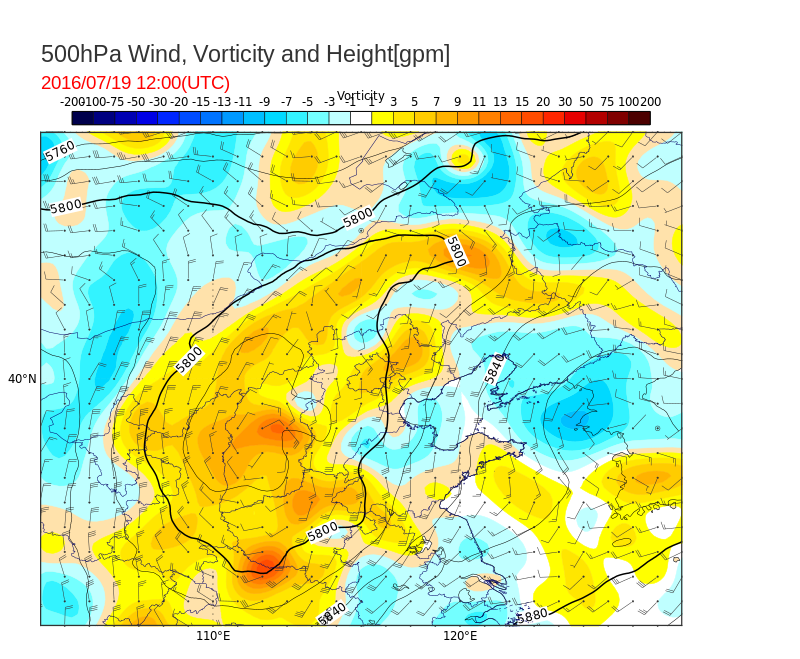

In [134]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import dynamics    
plot = dynamics.draw_vort_high(data['u500'].values, data['v500'].values, data['u500']['lon'].values, data['u500']['lat'].values,
                               gh=data['gh500'].values, map_region=map_regions['华北'], date_obj=date_obj, skip_vector=2)
plot

# 绘制位涡气压场

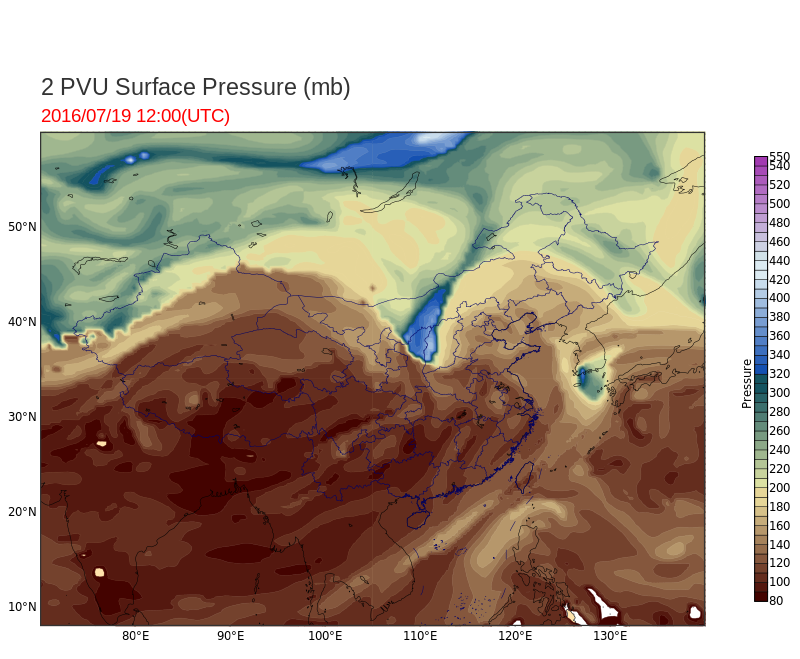

In [77]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import pv    
plot = pv.draw_pres_pv2(data['pres_pv2'].values, data['pres_pv2']['lon'].values, data['pres_pv2']['lat'].values,
                     map_region=map_regions['中国'], date_obj=date_obj)
plot

# 绘制整层可降水量

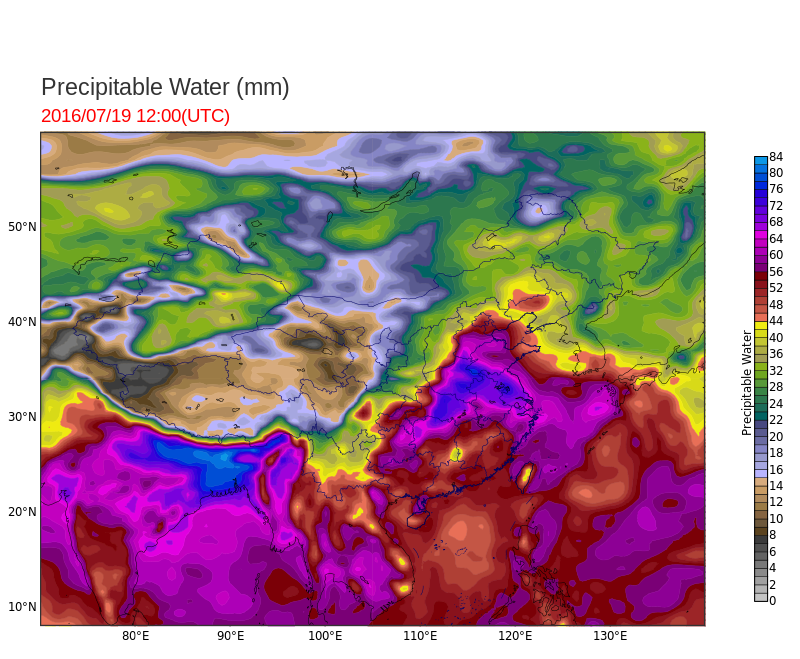

In [78]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import moisture        
plot = moisture.draw_pwat(data['pwat'].values, data['pwat']['lon'].values, data['pwat']['lat'].values,
                 map_region=map_regions['中国'], date_obj=date_obj)
plot

# 绘制海平面气压场

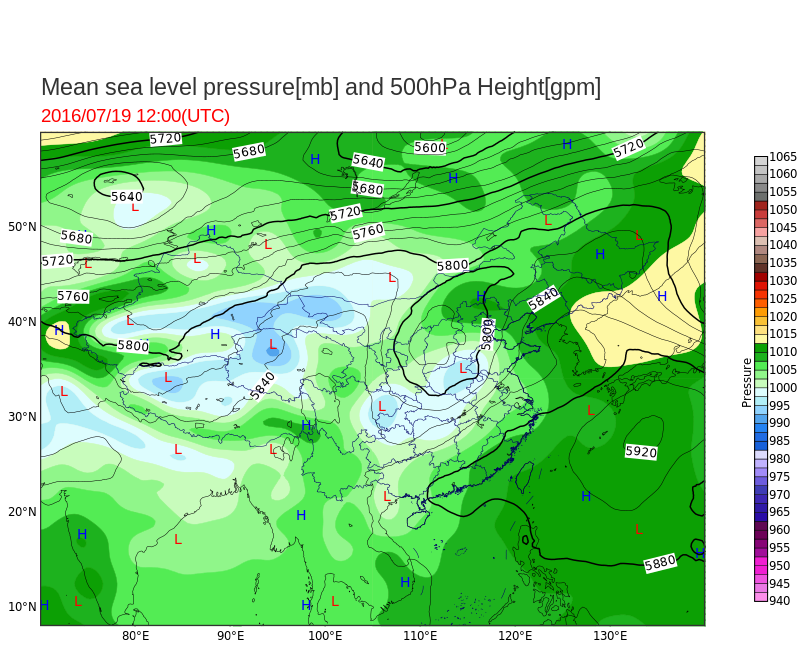

In [86]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import dynamics        
plot = dynamics.draw_mslp(data['mslp'].values, data['mslp']['lon'].values, data['mslp']['lat'].values,
                          gh=data['gh500'].values, map_region=map_regions['中国'], date_obj=date_obj)
plot

## 绘制200hPa高度场

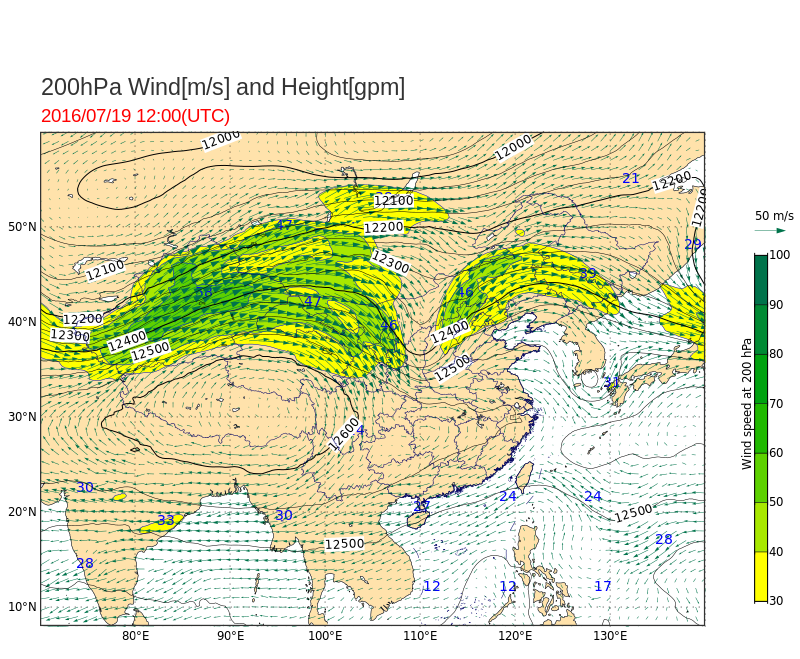

In [9]:
from nmc_met_graphics.util import  get_map_regions
map_regions = get_map_regions()

from nmc_met_graphics.magics import dynamics
plot = dynamics.draw_wind_upper(data['u200'].values, data['v200'].values, data['u200']['lon'].values, data['u200']['lat'].values,
                                gh=data['gh200'].values, skip_vector=2, map_region=map_regions['中国'], date_obj=date_obj)
plot

# 绘制850hPa温度场

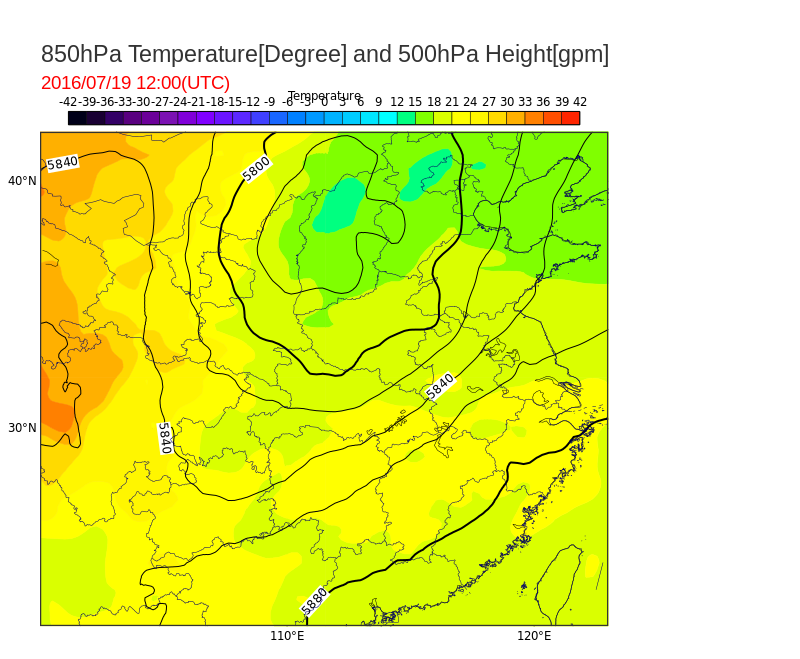

In [136]:
from nmc_met_graphics.util import  get_map_regions
from nmc_met_graphics.magics import util, map_set
map_regions = get_map_regions()

from nmc_met_graphics.magics import thermal
        
plot = thermal.draw_temp_high(data['t850'].values, data['t850']['lon'].values, data['t850']['lat'].values,
                              gh=data['gh500'].values, map_region=map_regions['华中'], date_obj=date_obj)
plot

## 绘制850hPa风场

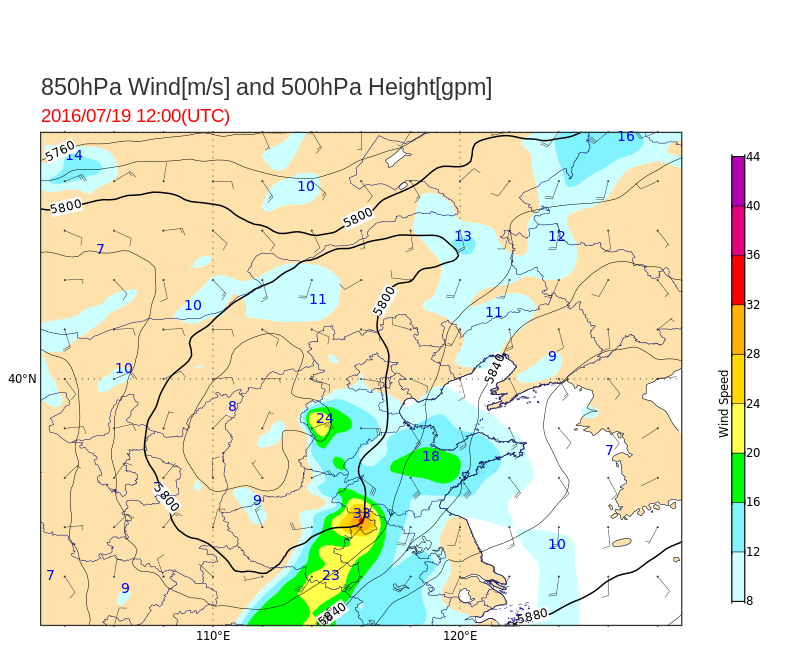

In [21]:
from nmc_met_graphics.util import  get_map_regions
from nmc_met_graphics.magics import util, map_set
map_regions = get_map_regions()

from nmc_met_graphics.magics.dynamics import draw_wind_high
plot = draw_wind_high(data['u850'].values, data['v850'].values, data['u850']['lon'].values, data['u850']['lat'].values,
                      gh=data['gh500'].values, map_region=map_regions['华北'], date_obj=date_obj)
plot

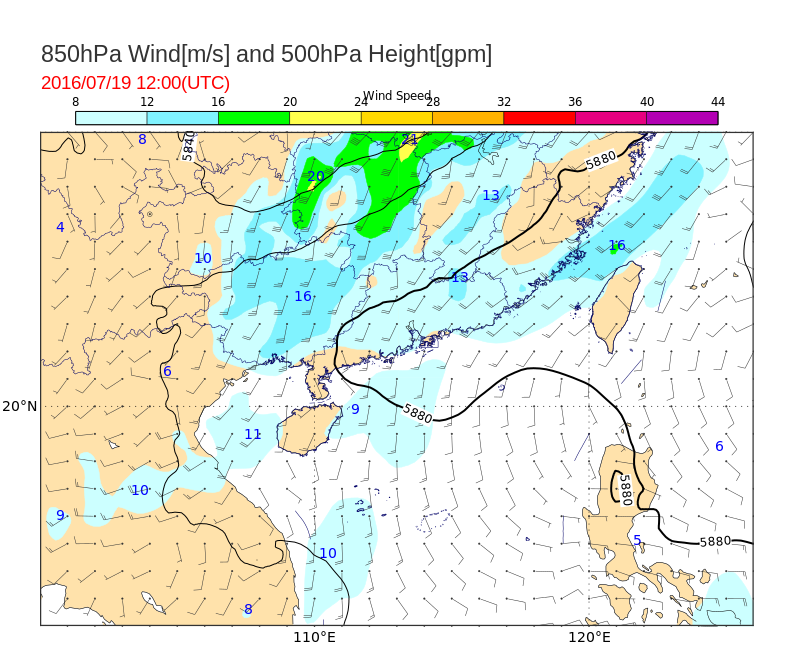

In [24]:
from nmc_met_graphics.util import  get_map_regions
from nmc_met_graphics.magics import util, map_set
map_regions = get_map_regions()

from nmc_met_graphics.magics.dynamics import draw_wind_high
plot = draw_wind_high(data['u925'].values, data['v925'].values, data['u925']['lon'].values, data['u925']['lat'].values,
                      gh=data['gh500'].values, skip_vector=2, map_region=map_regions['华南'], date_obj=date_obj)
plot